In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf

2021-12-19 16:34:00.682704: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-19 16:34:00.682745: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
games_season = pd.read_csv("../basketball_data/games_season.csv")
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [5]:
# Imports
from keras.layers import Embedding
from numpy import unique

# Count the unique number of teams
n_teams = unique(games_season['team_1']).shape[0]

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')

In [7]:
# Imports
from keras.layers import Input, Embedding, Flatten
from keras.models import Model

# Create an input layer for the team ID
teamid_in = Input(shape=(1,))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

### Make an input layer for home vs. away

Now you will make an improvement to the model you used in the previous chapter for regular season games. You know there is a well-documented home-team advantage in basketball, so you will add a new input to your model to capture this effect.

This model will have three inputs: team_id_1, team_id_2, and home. The team IDs will be integers that you look up in your team strength model from the previous chapter, and home will be a binary variable, 1 if team_1 is playing at home, 0 if they are not.

The team_strength_model you used in the previous chapter has been loaded into your workspace. After applying it to each input, use a Concatenate layer to join the two team strengths and with the home vs away variable, and pass the result to a Dense layer.

In [5]:
from keras.layers import Concatenate, Dense, Input

In [7]:
# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# Lookup the team inputs in the team strength model
# team_1_strength = team_strength_model(team_in_1)
# team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_in_1, team_in_2, home_in])
out = Dense(1)(out)

2021-12-19 16:34:40.554400: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-19 16:34:40.554445: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-19 16:34:40.554473: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Rabie): /proc/driver/nvidia/version does not exist
2021-12-19 16:34:40.554762: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Import the model class
from keras.models import Model

# Make a Model
model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [10]:
games_tourney = pd.read_csv('../basketball_data/games_tourney.csv')

In [12]:
# Fit the model to the games_season dataset
model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=1,
          verbose=True,
          validation_split=.10,
          batch_size=2048)

# Evaluate the model on the games_tourney dataset
print(model.evaluate([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']],
               games_tourney['score_diff'], verbose=True))

133/133 [==============================] - 0s 1ms/step - loss: 2527.4731
2527.47314453125


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team-1-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Team-2-In (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
Home-In (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 3)            0           Team-1-In[0][0]                  
                                                                 Team-2-In[0][0]              

### Plotting models

In addition to summarizing your model, you can also plot your model to get a more intuitive sense of it. Your model is available in the workspace.

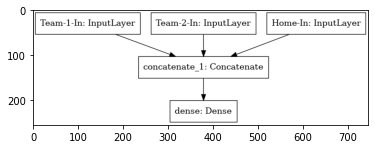

In [15]:
# Imports
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

# Plot the model
plot_model(model, to_file='model.png')

# Display the image
data = plt.imread('model.png')
plt.imshow(data)
plt.show()

### Add the model predictions to the tournament data

In lesson 1 of this chapter, you used the regular season model to make predictions on the tournament dataset, and got pretty good results! Try to improve your predictions for the tournament by modeling it specifically.

You'll use the prediction from the regular season model as an input to the tournament model. This is a form of "model stacking."

To start, take the regular season model from the previous lesson, and predict on the tournament data. Add this prediction to the tournament data as a new column.

In [16]:
# Predict
games_tourney['pred'] = model.predict([games_tourney['team_1'],
                                             games_tourney['team_2'],
                                             games_tourney['home']])

### Create an input layer with multiple columns

In this exercise, you will look at a different way to create models with multiple inputs. This method only works for purely numeric data, but its a much simpler approach to making multi-variate neural networks.

Now you have three numeric columns in the tournament dataset: 'seed_diff', 'home', and 'pred'. In this exercise, you will create a neural network that uses a single input layer to process all three of these numeric inputs.

This model should have a single output to predict the tournament game score difference.

In [17]:
# Create an input layer with 3 columns
input_tensor = Input((3,))

# Pass it to a Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Create a model
new_model = Model(input_tensor, output_tensor)

# Compile the model
new_model.compile(optimizer='adam', loss='mean_absolute_error')

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
games_tourney_train, games_tourney_test = train_test_split(games_tourney, train_size=0.8,\
                                                          random_state=123)

In [21]:
# Fit the model
new_model.fit(games_tourney_train[['home', 'seed_diff', 'pred']],
          games_tourney_train['score_diff'],
          epochs=1,
          verbose=True)

106/106 [==============================] - 1s 1ms/step - loss: 473.4288


In [23]:
# Evaluate the model on the games_tourney_test dataset
print(new_model.evaluate(games_tourney_test[['home', 'seed_diff', 'pred']],
          games_tourney_test['score_diff'], verbose=False))

278.9807434082031
